# Modeling

In [334]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate, cross_val_score,\
RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve,\
precision_recall_curve, f1_score, fbeta_score, confusion_matrix, classification_report, make_scorer, auc, log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter, OrderedDict
from scipy.stats import randint
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [350]:
# Import modules
from data_cleaning import convert
from model_eval import *

In [351]:
# For auto-reloading updated modules
%load_ext autoreload
%autoreload 2

In [184]:
# Load data
infile = open('merged_df2.pkl', 'rb')
df = pickle.load(infile)
infile.close()

df.head()
df.shape

,death,date,cdc_report_dt,onset_dt,age_group,hosp,icu,med_cond,"American Indian/Alaska Native, Non-Hispanic","Asian, Non-Hispanic",...,vent_incr,positive,pos_incr,pos_rate,pos_incr_rate,negative,neg_incr,recovered,tot_test_results,tot_test_results_incr
0,0,2020-04-01,2020-03-27,2020-03-27,3.0,0.0,NaN,NaN,0,0,...,NaN,224086.0,25791.0,0.180594,0.232918,984489.0,82981.0,7084.0,1240829.0,110730.0
1,0,2020-04-01,2020-03-19,2020-03-19,3.0,NaN,NaN,NaN,0,0,...,NaN,224086.0,25791.0,0.180594,0.232918,984489.0,82981.0,7084.0,1240829.0,110730.0
2,0,2020-04-01,2020-03-30,2020-03-30,3.0,0.0,NaN,NaN,0,0,...,NaN,224086.0,25791.0,0.180594,0.232918,984489.0,82981.0,7084.0,1240829.0,110730.0
3,0,2020-04-01,2020-04-01,2020-04-01,3.0,0.0,NaN,NaN,0,0,...,NaN,224086.0,25791.0,0.180594,0.232918,984489.0,82981.0,7084.0,1240829.0,110730.0
4,0,2020-04-01,2020-04-14,2020-03-31,3.0,0.0,NaN,0.0,0,0,...,NaN,224086.0,25791.0,0.180594,0.232918,984489.0,82981.0,7084.0,1240829.0,110730.0


(671435, 45)

From my preliminary modeling (see 'modeling1' notebook), I've decided to move forrward with the XGBoost model using all of my data. My 'icu' feature has a good number of missing values but it appears to be an important feature in classifying death so I would like to keep it in my model. I've tested simple imputation and imputation with KNN but these methods appear to change the data and correlations with the target to a non-insignificant degree. It is also difficult to accurately impute this kind of data, which can have potentially dangerous consequences in real-life application, so I would like to work with the pure data, which the XGBoost model allows me to do as it can handle missing values. The XGBoost model also performs best in terms of my evaluation metrics of recall and Fbeta with weight placed on recall.

In [101]:
# Filter dataset to include selected features
feat = ['death', 'hosp', 'icu', 'age_group', 'med_cond', 'pos_rate', 'pos_incr_rate', 'calc_pct_occ',
          'month', 'Male']

df1 = df[['death', 'hosp', 'icu', 'age_group', 'med_cond', 'pos_rate', 'pos_incr_rate', 'calc_pct_occ',
          'month', 'Male']]

*Partition data*

I will reserve a portion of my data as a hold-out set here and not touch it until I am done with all of my modeling.

In [102]:
X, y = df1.iloc[:,1:], df1.iloc[:,0]

# Partition data
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size = 0.2, random_state=33, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size = 0.2, random_state=14, stratify=y_tv)

### Optimizing XGBoost Model

**Iteration 1:**
- Initial features
- Default parameters

Starting with a baseline XGBoost model, we will compare sampling methods: balancing weights with built-in class parameter, random oversampling, random undersampling. We will forego the other sampling methods as we have null values in the data set and from our preliminary analysis, these random sampling methods appeared to be the best.

In [354]:
# Instantiate model
gbm = XGBClassifier(n_jobs=-1, random_state=42)

# Evaluate different sampling methods with train-test-split
compare_sampling2('XGBoost', gbm, X_tv, y_tv)

Balanced:
              train      test
precision  0.465051  0.456634
recall     0.935263  0.914367
f1         0.621210  0.609089
fbeta      0.777947  0.761667 

Random oversampler :
              train       val
precision  0.427223  0.421843
recall     0.952678  0.938146
f1         0.589906  0.581991
fbeta      0.764597  0.753661 

Random undersampler :
              train       val
precision  0.416632  0.411181
recall     0.952107  0.938995
f1         0.579625  0.571921
fbeta      0.757414  0.747173 



With XGBoost, the models are fairly well fit with all sampling methods but it looks like balancing the classes within the model performs the best. In particular, the Fbeta score is highest and recall is still >90%. I will move foward with balancing clases within the model.

In [46]:
# Confirm with cross validation
base_gbm = XGBClassifier(scale_pos_weight=14, n_jobs=-1, random_state=42)
cv(base_gbm, X_tv, y_tv)

,mean_score
test_accuracy,0.912734
train_accuracy,0.914465
test_precision,0.424036
train_precision,0.430083
test_recall,0.937667
train_recall,0.951840
test_f1,0.592464
train_f1,0.583977
test_fbeta,0.765986
train_fbeta,0.765986


From the cross-validation results, my model appears to be slightly overfit as my test precision and recall scores are slightly lower than my test scores. I will see if I can improve fit by adjusting my hyperparameters.

I will use RandomizedSearchCV to look for optimal parameters for my model to try to maximize recall.

In [54]:
# Instantiate base model
base_model = XGBClassifier(scale_pos_weight=14, random_state=42, n_jobs=-1)

# Parameter grid to use for search
parameters = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2 , 0.3],
    "colsample_bytree": [0.1, 0.2, 0.3, 0.4]
}

# Perform RandomizedSearchCV
best_params, best_score = tune(base_model, parameters, 10, 5, X_tv[feat], y_tv)

Cross Val Mean: 0.941, Cross Val Stdev: 0.004
Best Score: 0.911
Best Parameters: {'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.3}


In [103]:
# Re-run model with best parameters
gbm_best = XGBClassifier(min_child_weight=1, max_depth=6, learning_rate=0.3, gamma=0, colsample_bytree=0.3,
                         scale_pos_weight=14, n_jobs=-1, random_state=42)

# Evaluate with cross-validation
cv(gbm_best, X_tv, y_tv)

,mean_score
test_accuracy,0.910993
train_accuracy,0.911554
test_precision,0.419127
train_precision,0.421046
test_recall,0.939577
train_recall,0.944066
test_f1,0.582363
train_f1,0.579666
test_fbeta,0.756197
train_fbeta,0.756197


I actually get worse recall and Fbeta than in my cross-validation run but my model does appear to fit slightly better. I will continue to try to optimize by: 1) adjusting the hyperparameters to maximize my important metrics while also improving fit, 2) adjusting features.

In [107]:
# Look at feature importance for model run with best features
gbm_best.fit(X_tv, y_tv)

for feature in zip(df1.columns, gbm_best.feature_importances_):
    print(feature)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

('death', 0.5383793)
('hosp', 0.06786048)
('icu', 0.26976967)
('age_group', 0.06933711)
('med_cond', 0.0042261053)
('pos_rate', 0.020897537)
('pos_incr_rate', 0.005123259)
('calc_pct_occ', 0.019874644)
('month', 0.0045319316)


It looks like 'month' and 'pos_incr_rate' do not contribute signifiantly to the model. I will remove them one at a time to see if performance improves.

In [105]:
# Changed features: removed 'month'
# Default parameters
df2 = df[['death', 'hosp', 'icu', 'age_group', 'med_cond', 'pos_rate', 'pos_incr_rate', 'calc_pct_occ', 'Male']]
X2, y2 = df2.iloc[:,1:], df2.iloc[:,0]

# Partition data
X2_tv, X2_test, y2_tv, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=33, stratify=y2)

# Instantiate & evaluate model
gbm2 = XGBClassifier(scale_pos_weight=14, n_jobs=-1, random_state=42)
cv(gbm2, X2_tv, y2_tv)

,mean_score
test_accuracy,0.912555
train_accuracy,0.914569
test_precision,0.423434
train_precision,0.430362
test_recall,0.936527
train_recall,0.951398
test_f1,0.592643
train_f1,0.583184
test_fbeta,0.765935
train_fbeta,0.765935


This iteration is comparable to my baseline model so it looks like removing this feature did not change my model much.

In [111]:
# Feature analysis for gbm2
gbm2.fit(X2_tv, y2_tv)

for feature in zip(X2_tv.columns, gbm2.feature_importances_):
    print(feature)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

('hosp', 0.2855856)
('icu', 0.048577856)
('age_group', 0.57978183)
('med_cond', 0.01743939)
('pos_rate', 0.039011203)
('pos_incr_rate', 0.011586573)
('calc_pct_occ', 0.007049599)
('Male', 0.010967932)


It looks the importance of my 'pos_incr_rate' feature increased, which may indicate that these two features were colinear.

In [109]:
# Changed features: removed 'month' & 'pos_incr_rate'
# Default parameters
df3 = df[['death', 'hosp', 'icu', 'age_group', 'med_cond', 'pos_rate', 'calc_pct_occ', 'Male']]
X3, y3 = df3.iloc[:,1:], df3.iloc[:,0]

# Partition data
X3_tv, X3_test, y3_tv, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state=33, stratify=y2)

# Instantiate & evaluate model
gbm3 = XGBClassifier(scale_pos_weight=14, n_jobs=-1, random_state=42)
cv(gbm3, X3_tv, y3_tv)

,mean_score
test_accuracy,0.912324
train_accuracy,0.914180
test_precision,0.422821
train_precision,0.429211
test_recall,0.937468
train_recall,0.951483
test_f1,0.591567
train_f1,0.582786
test_fbeta,0.765249
train_fbeta,0.765249


This iteration also did not improve my model much so it looks like these two features may not be contribute much to my model.

In [113]:
# Feature analysis for gbm3
# gbm3.fit(X3_tv, y3_tv)
for feature in zip(X3_tv.columns, gbm3.feature_importances_):
    print(feature)

('hosp', 0.31460524)
('icu', 0.051151857)
('age_group', 0.5635287)
('med_cond', 0.017739447)
('pos_rate', 0.034613386)
('calc_pct_occ', 0.0069700787)
('Male', 0.011391341)


We see that 'calc_pct_occ' is now less important. We will try trimming this feature and re-evaluating the model.

In [114]:
# Changed features: removed 'month', 'pos_incr_rate', 'calc_pct_occ'
# Default parameters
df4 = df[['death', 'hosp', 'icu', 'age_group', 'med_cond', 'pos_rate', 'Male']]
X4, y4 = df4.iloc[:,1:], df4.iloc[:,0]

# Partition data
X4_tv, X4_test, y4_tv, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state=33, stratify=y4)

# Instantiate & evaluate model
gbm4 = XGBClassifier(scale_pos_weight=14, n_jobs=-1, random_state=42)
cv(gbm4, X4_tv, y4_tv)

,mean_score
test_accuracy,0.912041
train_accuracy,0.913747
test_precision,0.422104
train_precision,0.427898
test_recall,0.938864
train_recall,0.950956
test_f1,0.590218
train_f1,0.582370
test_fbeta,0.764140
train_fbeta,0.764140


My model's performance improved slightly. It may have been the case that these less important features that were removed were making my model more complex without improving its performance.

In [115]:
# Feature analysis for gbm4
gbm4.fit(X4_tv, y4_tv)

for feature in zip(X4_tv.columns, gbm4.feature_importances_):
    print(feature)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

('hosp', 0.3175025)
('icu', 0.051567584)
('age_group', 0.58032763)
('med_cond', 0.017301263)
('pos_rate', 0.022099206)
('Male', 0.011201649)


We now have a better feature importance distribution. I also tried some iterations where I removed the least 3 important features but my model performed better with these features included. I will include these 6 features in my final model.

I will now try to further tune my hyperparameters to improve my model's fit.

Iterations:
- Decreased max_depth
- Increased gamma
- Increased reg_lambda
- Increased min_child_weight

After various iterations, this is the model with the hyperparameters that optimized recall and Fbeta and yielded good fit. My precision remained lower at ~0.41-0.42 but for the scope of this project and my goal of classifying death, I prioritize recall.

In [186]:
gbm4_adj3 = XGBClassifier(scale_pos_weight=14, n_jobs=-1, random_state=42, max_depth=3)
cv(gbm4_adj3, X4_tv, y4_tv)

,mean_score
test_accuracy,0.909675
train_accuracy,0.909785
test_precision,0.415675
train_precision,0.416071
test_recall,0.943339
train_recall,0.944686
test_f1,0.577701
train_f1,0.577060
test_fbeta,0.753277
train_fbeta,0.753277


In [187]:
# Run model on test set
cv(gbm4_adj3, X4_test.values, y4_test.values)

,mean_score
test_accuracy,0.909738
train_accuracy,0.910654
test_precision,0.415525
train_precision,0.418645
test_recall,0.938775
train_recall,0.946357
test_f1,0.580488
train_f1,0.576050
test_fbeta,0.755805
train_fbeta,0.755805


Running the model on my test set yielded a consistent result with high recall and Fbeta scores. It looks like this is my final model!

In [202]:
# Re-name and save model
xgb = gbm4_adj3

In [203]:
# Pickle final model
pickle_out = open("classifier2.pkl", "wb") 
pickle.dump(xgb, pickle_out) 
pickle_out.close()

In [247]:
# Final feature analysis
feature_list = [list(feature) for feature in zip(X4.columns, xgb.feature_importances_)]
feature_dict = {}
for f_list in feature_list:
    feature_dict[f_list[0]] = f_list[1]

feature_s = pd.Series(feature_dict).sort_values(ascending=True)
fi_df = pd.DataFrame(feature_s).reset_index()
fi_df.rename(columns={'index': 'feature', 0: 'importance'}, inplace=True)
fi_df

,feature,importance
0,Male,0.015080
1,pos_rate,0.023490
2,med_cond,0.025500
3,icu,0.060572
4,hosp,0.286691
5,age_group,0.588667


It looks like age group and hospitalization in particular contribute significantly to my model, which corresponds to my observations during my EDA.

<Figure size 360x288 with 0 Axes>

<BarContainer object of 6 artists>

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Feature Importance')

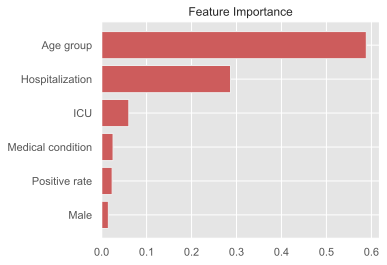

In [300]:
# Prep feature importance analysis for plotting
fi_df.iloc[0,0] = 'Male'
fi_df.iloc[1,0] = 'Positive rate'
fi_df.iloc[2,0] = 'Medical condition'
fi_df.iloc[3,0] = 'ICU'
fi_df.iloc[4,0] = 'Hospitalization'
fi_df.iloc[5,0] = 'Age group'

# Plotting
plt.figure(figsize=(5,4))
plt.barh(fi_df['feature'], fi_df['importance'], color='indianred')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Feature Importance', fontsize=12);

In [171]:
# Final metric evaluation
y_pred = xgb.predict(X4_test)
preds = xgb.predict_proba(X4_test)

# Classification report
print(classification_report(y4_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    125516
           1       0.42      0.95      0.58      8771

    accuracy                           0.91    134287
   macro avg       0.71      0.93      0.76    134287
weighted avg       0.96      0.91      0.93    134287



<Figure size 600x400 with 0 Axes>

<AxesSubplot:>

(array([0.5, 1.5]), [Text(0.5, 0, 'No Death'), Text(1.5, 0, 'Death')])

(array([0.5, 1.5]), [Text(0, 0.5, 'No Death'), Text(0, 1.5, 'Death')])

Text(0.5, 12.250000000000002, 'Predicted')

Text(107.25000000000007, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

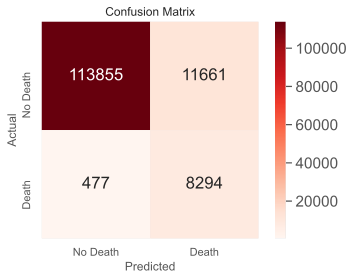

In [312]:
# Confusion matrix
confusion = confusion_matrix(y4_test, y_pred)

# Plot confusion matrix
plt.figure(dpi=100)
sns.heatmap(confusion, cmap=plt.cm.Reds, annot=True, square=True, fmt='g',
        xticklabels=['No Death', 'Death'],
        yticklabels=['No Death', 'Death'])

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)

We see that this model was able to capture a majority (>93%) of the actual deaths, which is what we want. We do have a fairly high number of false positives but we care more about capturing as many true negatives as we can.

<Figure size 500x500 with 0 Axes>

Text(0.5, 0, 'Threshold')

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Precision and Recall Curves')

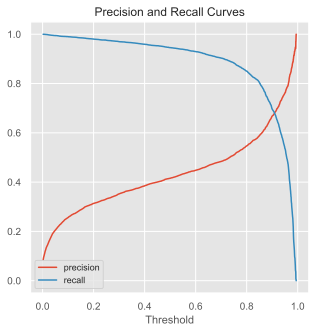

In [318]:
# Precision-recall curve with threshold
precision, recall, thresholds = precision_recall_curve(y4_test, preds[:,1])

plt.figure(dpi=100, figsize=(5,5))
plt.plot(thresholds, precision[1:], label='precision')
plt.plot(thresholds, recall[1:], label='recall')
plt.legend(loc='best', fontsize=9)
plt.xlabel('Threshold', fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Precision and Recall Curves', fontsize=12);

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve')

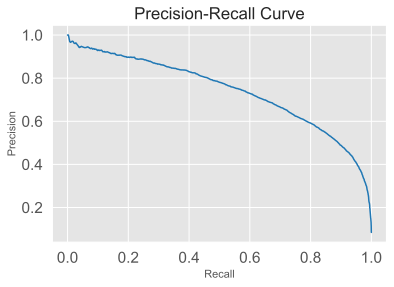

Precision-recall curve AUC:  0.7410063316963925


In [328]:
# Precision vs. recall curve
precision, recall, _ = precision_recall_curve(y4_test, preds[:,1])
plt.plot(recall, precision, color='tab:blue')
plt.xlabel('Recall', fontsize=11)
plt.ylabel('Precision', fontsize=11)
plt.title('Precision-Recall Curve')
plt.show()

pr_auc = auc(recall, precision)
print('Precision-recall curve AUC: ', pr_auc)

We see that precision decreases with decrease in recall and vice versa. This makes sense in the context of clinical decision making when things are not so clear cut and you often end up risking overdiagnosis or overtreatment for the sake of not missing any positive cases, especially in high-risk situations. It is always good to strike a balance as overdiagnosis and overtreatment can also be costly and dangerous but it is important to weigh the risks and benefits of each scenario. In a case like the objective of this project where we want to predict a rare but very high risk and devastating situation like death, I would prioritize maximizing my recall even if it means sacrificing some precision as long as the potential risks do not outweigh the benefits.

<Figure size 360x360 with 0 Axes>

(-0.05, 1.05)

(-0.05, 1.05)

Text(0.5, 0, 'False positive rate')

Text(0, 0.5, 'True positive rate')

Text(0.5, 1.0, 'ROC curve')

ROC AUC score =  0.9746712005403546


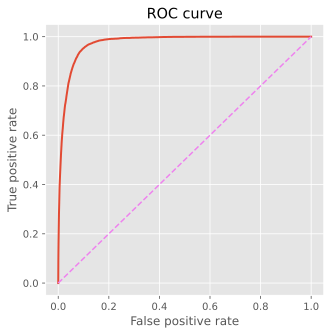

In [261]:
# ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y4_test, preds[:,1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('roc.svg', dpi=100, bbox_inches='tight')

print("ROC AUC score = ", roc_auc_score(y4_test, preds[:,1]))

Wee see that the AUC of the ROC curve is very high but this metric is less meaningful in this case since my classes were imbalanced in favor of the negative class.